In [1]:
# from jax.config import config
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import moscot as mt
import squidpy as sq
import numpy as np
from pathlib import Path
import pickle
import scipy
import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData
import cellrank as cr
import pandas as pd

# config.update("jax_enable_x64", True)
# # sc.set_figure_params()
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/moscot_paper/mosta/mosta_filter_umap_OUTPUT.h5ad"
)

In [3]:
corrs = pd.read_csv(
    "/lustre/groups/ml01/workspace/moscot_paper/mosta/corr_df_drivers.csv.gz"
)
df = pd.read_csv(
    "/lustre/groups/ml01/workspace/moscot_paper/mosta/Mus_musculus_TF", sep="\t"
)

In [4]:
from typing import *
from types import MappingProxyType
import anndata


class MostaKernel(cr.kernels.TransportMapKernel):
    def compute_transition_matrix(
        self,
        tmaps: Dict[Tuple[float, float], anndata.AnnData],
        threshold: Optional[str] = "auto",
        self_transitions: Union[
            Literal["uniform", "diagonal", "connectivities", "all"],
            Sequence[float],
        ] = "connectivities",
        conn_weight: Optional[float] = None,
        conn_kwargs: Mapping[str, Any] = MappingProxyType({}),
    ):
        self._tmaps = tmaps

        if threshold is not None:
            self._threshold_transport_maps(
                self.transport_maps, threshold=threshold, copy=False
            )

        tmap = self._restich_tmaps(
            self.transport_maps,
            self_transitions=self_transitions,
            conn_weight=conn_weight,
            **conn_kwargs,
        )

        self.transition_matrix = tmap.X
        return self

    def _compute_tmap(self):
        raise NotImplementedError()

In [5]:
from cellrank.estimators import GPCCA

g = GPCCA.read("/lustre/groups/ml01/workspace/moscot_paper/mosta/gpcca.pkl.pickle")

In [7]:
pd.set_option("display.max_columns", 50)
corrs.sort_values(by="Heart_corr", ascending=False).head(50).merge(
    right=df, how="left", left_on="gene_short_name", right_on="Symbol"
)

,gene_short_name,Dorsal root ganglion_corr,Dorsal root ganglion_pval,Dorsal root ganglion_qval,Dorsal root ganglion_ci_low,Dorsal root ganglion_ci_high,Brain_corr,Brain_pval,Brain_qval,Brain_ci_low,Brain_ci_high,Spinal cord_corr,Spinal cord_pval,Spinal cord_qval,Spinal cord_ci_low,Spinal cord_ci_high,Heart_corr,Heart_pval,Heart_qval,Heart_ci_low,Heart_ci_high,Epidermis_corr,Epidermis_pval,Epidermis_qval,Epidermis_ci_low,Epidermis_ci_high,Muscle_corr,Muscle_pval,Muscle_qval,Muscle_ci_low,Muscle_ci_high,Liver_corr,Liver_pval,Liver_qval,Liver_ci_low,Liver_ci_high,Cartilage primordium_corr,Cartilage primordium_pval,Cartilage primordium_qval,Cartilage primordium_ci_low,Cartilage primordium_ci_high,Species,Symbol,Ensembl,Family,Protein,Entrez_ID
0,Hba-a1,-0.342394,0.000000e+00,0.000000e+00,-0.344795,-0.339990,-0.340029,0.000000e+00,0.000000e+00,-0.342434,-0.337620,-0.390907,0.000000e+00,0.000000e+00,-0.393210,-0.388599,0.514960,0.0,0.0,0.512958,0.516957,-0.211436,0.000000e+00,0.000000e+00,-0.214034,-0.208834,-0.302390,0.000000e+00,0.000000e+00,-0.304861,-0.299915,0.467229,0.000000e+00,0.000000e+00,0.465099,0.469354,-0.344340,0.000000e+00,0.000000e+00,-0.346737,-0.341939,NaN,NaN,NaN,NaN,NaN,NaN
1,Hba-a2,-0.332251,0.000000e+00,0.000000e+00,-0.334669,-0.329827,-0.326863,0.000000e+00,0.000000e+00,-0.329292,-0.324430,-0.377714,0.000000e+00,0.000000e+00,-0.380045,-0.375379,0.500003,0.0,0.0,0.497960,0.502042,-0.215117,0.000000e+00,0.000000e+00,-0.217711,-0.212520,-0.294850,0.000000e+00,0.000000e+00,-0.297333,-0.292364,0.456850,0.000000e+00,0.000000e+00,0.454694,0.459001,-0.335382,0.000000e+00,0.000000e+00,-0.337795,-0.332964,NaN,NaN,NaN,NaN,NaN,NaN
2,Hbb-bt,-0.313448,0.000000e+00,0.000000e+00,-0.315900,-0.310992,-0.296237,0.000000e+00,0.000000e+00,-0.298717,-0.293752,-0.349225,0.000000e+00,0.000000e+00,-0.351613,-0.346834,0.432871,0.0,0.0,0.430657,0.435080,-0.203932,0.000000e+00,0.000000e+00,-0.206539,-0.201323,-0.284867,0.000000e+00,0.000000e+00,-0.287365,-0.282364,0.455955,0.000000e+00,0.000000e+00,0.453796,0.458108,-0.322553,0.000000e+00,0.000000e+00,-0.324989,-0.320112,NaN,NaN,NaN,NaN,NaN,NaN
3,Alas2,-0.170176,0.000000e+00,0.000000e+00,-0.172818,-0.167532,-0.164672,0.000000e+00,0.000000e+00,-0.167319,-0.162023,-0.175041,0.000000e+00,0.000000e+00,-0.177678,-0.172402,0.418784,0.0,0.0,0.416537,0.421026,-0.237634,0.000000e+00,0.000000e+00,-0.240200,-0.235064,-0.202572,0.000000e+00,0.000000e+00,-0.205180,-0.199961,0.208575,0.000000e+00,0.000000e+00,0.205971,0.211177,-0.221340,0.000000e+00,0.000000e+00,-0.223927,-0.218751,NaN,NaN,NaN,NaN,NaN,NaN
4,Hba-x,-0.105509,0.000000e+00,0.000000e+00,-0.108199,-0.102817,-0.136561,0.000000e+00,0.000000e+00,-0.139231,-0.133889,-0.128649,0.000000e+00,0.000000e+00,-0.131324,-0.125972,0.400841,0.0,0.0,0.398555,0.403123,-0.087311,0.000000e+00,0.000000e+00,-0.090011,-0.084610,-0.113343,0.000000e+00,0.000000e+00,-0.116029,-0.110656,0.020724,2.185813e-50,5.229217e-50,0.018004,0.023444,-0.141974,0.000000e+00,0.000000e+00,-0.144639,-0.139306,NaN,NaN,NaN,NaN,NaN,NaN
5,Hbb-y,-0.118994,0.000000e+00,0.000000e+00,-0.121676,-0.116311,-0.155549,0.000000e+00,0.000000e+00,-0.158204,-0.152893,-0.151771,0.000000e+00,0.000000e+00,-0.154429,-0.149111,0.390226,0.0,0.0,0.387916,0.392530,-0.017424,3.988679e-36,1.131540e-35,-0.020144,-0.014703,-0.118927,0.000000e+00,0.000000e+00,-0.121609,-0.116243,0.025205,1.139691e-73,2.907376e-73,0.022485,0.027925,-0.139014,0.000000e+00,0.000000e+00,-0.141681,-0.136344,NaN,NaN,NaN,NaN,NaN,NaN
6,Hbb-bs,-0.258701,0.000000e+00,0.000000e+00,-0.261239,-0.256160,-0.231001,0.000000e+00,0.000000e+00,-0.233575,-0.228423,-0.287910,0.000000e+00,0.000000e+00,-0.290404,-0.285412,0.353411,0.0,0.0,0.351027,0.355790,-0.155949,0.000000e+00,0.000000e+00,-0.158603,-0.153292,-0.225042,0.000000e+00,0.000000e+00,-0.227624,-0.222457,0.359639,0.000000e+00,0.000000e+00,0.357267,0.362006,-0.247235,0.000000e+00,0.000000e+00,-0.249788,-0.244678,NaN,NaN,NaN,NaN,NaN,NaN
7,Apex2,-0.191701,0.000000e+00,0.000000e+00,-0.194321,

In [11]:
model = cr.models.GAM(adata, n_knots=6, distribution="normal").fit()

RuntimeError: Fatal model failure `<FailedModel[origin=GAM[gene=None, lineage=None, model=GAM(callbacks=['deviance', 'diffs'], distribution='normal', fit_intercept=True, link='log', max_iter=2000, terms=s(0), tol=0.0001, verbose=False)]]>`.

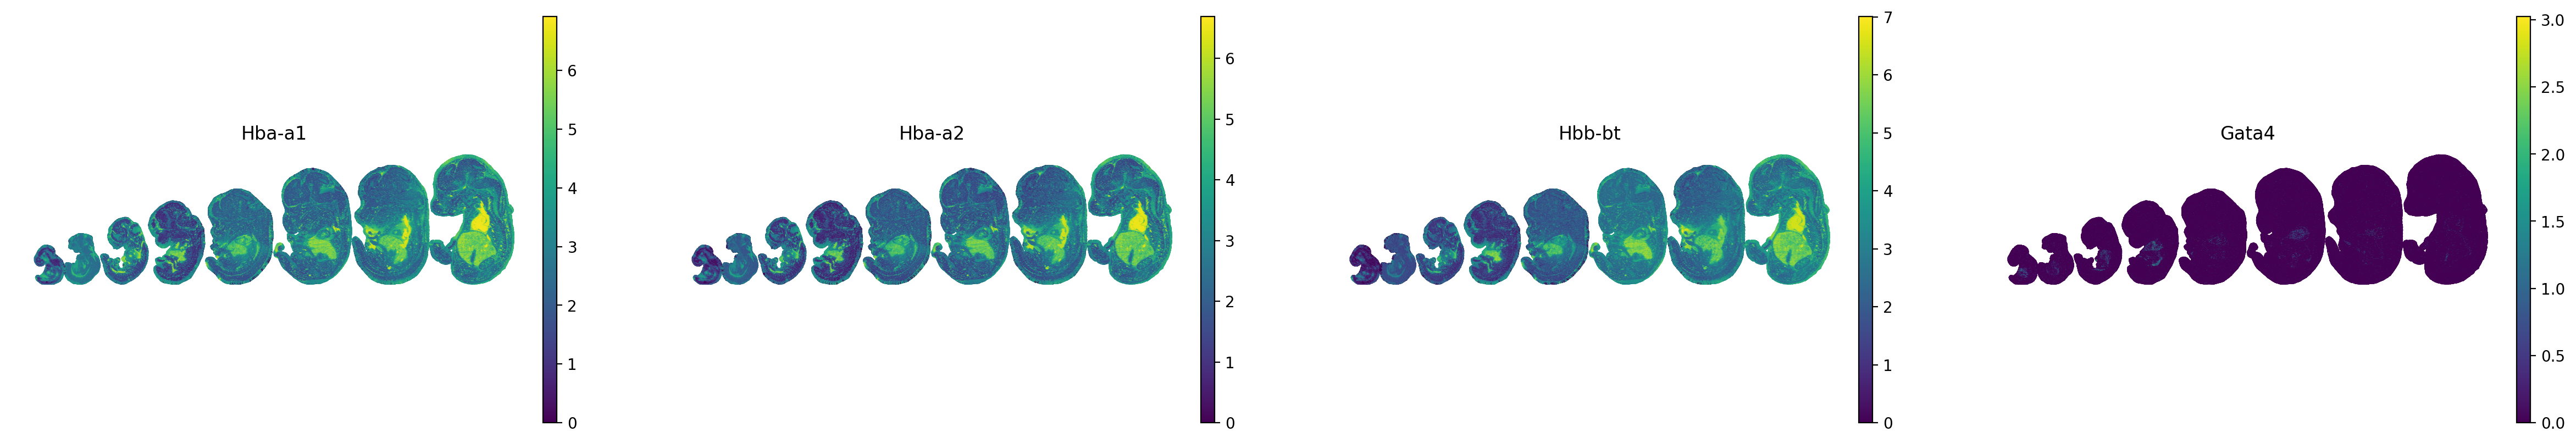

In [8]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Hba-a1", "Hba-a2", "Hbb-bt", "Gata4"],
    frameon=False,
    dpi=200,
)